Jesus is a Rasin

In [1]:
import cupy
from cupy import fft
import tifffile
import math
import numpy as np
import ComputeGaussianPSF as CG

import matplotlib.pyplot as plt

from pypher.pypher import (parse_args, format_kernel_header,
                           imrotate, imresample, trim, zero_pad,
                           psf2otf, homogenization_kernel)
import RL_TV
import threading


Loading all the Shazbot

In [2]:
# stack_filename = '/home/imaging/Documents/MATLAB/Matlab Magic/Extended-Volume-3D-deconvolution-master/Extended-Volume-3D-deconvolution-master/code/aligned_vol_crop2.tif'
stack_filename = r'G:\My Drive\MATLAB\Extended-Volume-3D-deconvolution-master\Extended-Volume-3D-deconvolution-master\code\aligned_vol_crop2.tif'
stack = tifffile.imread(stack_filename)

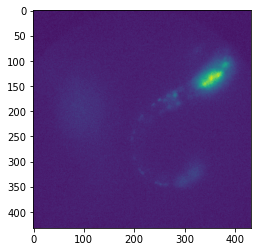

In [3]:
plt.imshow(stack[273,13,:,: ])                                                                                                                                                                                                                                                                                                                                                                                             

In [4]:

# matlab code
# [XX,YY,ZZ,TT] = size(stack); <--- needs to be [TT,ZZ,YY,XX]

dims = stack.shape
XX = dims[3]
YY = dims[2]
ZZ = dims[1]
TT = dims[0]

# %imaging parameters (Original)
# % NA = 0.4; % objective numerical aperture
# % dz = 20.56; % delta z, um
# % dx = 1.083; % laterial pixel size, um
# % lambda = 0.51; % wavelength, um
# % index = 1.0; % refractive index

# %OURS M25
# % imaging parameters
NumAp = 1.4 # objective numerical aperture
dz = 2.0 # % delta z, um
dx = 0.380 # % laterial pixel size, um
waveLength = 0.515 # % wavelength, um
index = 1.51 # % refractive index

# optimization parameters
TV_reg = 0.0005 # amount of TV regularization
xy_pad = 50 # lateral volume extension
z_pad = 8 # axial volume extension
# Original settings
# outer_iter = 20 # number of outer iterations of EV-3D
# inner_iter = 80 # number of inner iterations of EV-3D

# rl_iter = 200 # number of iteratins for traditional RL-3D
outer_iter = 10 # number of outer iterations of EV-3D
inner_iter = 40 # number of inner iterations of EV-3D

rl_iter = 200 # number of iteratins for traditional RL-3D

The thing it does

41
(41,)
xi shape: (41,)
L: 202.16 dx: 0.38 Nx: 532


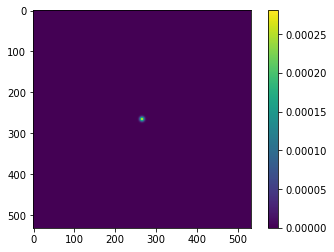

In [5]:
## EV-3D deconvolution
Nx = XX + 2*xy_pad
Ny = YY + 2*xy_pad ## image should be square so XX == YY
Nz = ZZ + 2*z_pad

# psf = ComputeGaussianPSF(NA,lambda,dx,dz,Nx,floor(Nz/2),index);
psf = CG.ComputeGaussianPSF(NumAp,waveLength,dx,dz,Nx,math.floor(Nz/2),index)

''' The Pypher psf2otf libray used np.fft.fft2 instead of fftn
    And does not match the matlab output for that reason   '''
    
otf = np.complex32(psf2otf(psf, psf.shape))
#otf = np.reshape(otf, (otf.size,), order='C')
# print(psf.dtype)
# print(psf.shape)
# print(psf[0 ,47:79, 47:79])
# print(otf.dtype)
# print(otf.shape)
# print(otf[0 ,47:79, 47:79])
plt.imshow(psf[19,:,:])
plt.colorbar()
# print(type(psf[0,0,0]))
# print(type(otf[12,215,215]))
# print(otf[12,215,215])
#plt.imshow(np.abs(otf[0,:,:]))

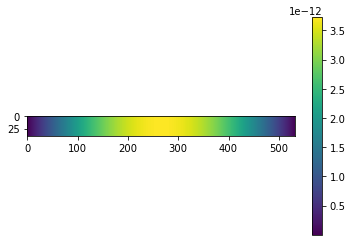

In [6]:
plt.imshow(np.abs(np.fft.fftshift(otf[:,266,:])))
plt.colorbar()

In [7]:
def les_thread(image_num = 0):
    dev0 = cupy.cuda.Device(0)
    im_ev = np.pad(stack[image_num,:,:,:], ((z_pad,),(xy_pad,), (xy_pad,)), 'edge' )
    im_ev = np.reshape(im_ev.astype(np.float32), (im_ev.size,), order='C')
    im_mask = np.pad(stack[image_num,:,:,:], ((z_pad,), (xy_pad,), (xy_pad,)), 'constant', constant_values=(0,) )
    im_mask = np.ravel_multi_index(np.where(im_mask>0),im_mask.shape)
    temp = stack[image_num,:,:,:].astype(np.float32)
    obs = temp[np.where(temp != 0)] # corresponding pixel values of V_I

    obs_cp = cupy.asarray(obs)
    im_ev_cp = cupy.asarray(im_ev)
    
    im_mask_cp = cupy.asarray(im_mask)
    est = cupy.asarray(cupy.zeros((Nz*Ny*Nx,),dtype=cupy.float32), order='C')

    for i in range(outer_iter):
        with dev0:
            est = RL_TV.RL_TV(im_ev_cp, otf_cp, inner_iter, TV_reg, Nz, Ny, Nx, dev0)
            im_ev_cp = cupy.copy(cupy.real(cupy.fft.ifftn(cupy.fft.fftn(cupy.reshape(est, (Nz, Ny, Nx)))*otf_cp)).astype(cupy.float32))
            im_ev_cp = cupy.reshape(cupy.maximum(im_ev_cp, 0), (im_ev_cp.size,), order='C') # maximum function =/= max function
            ''' Need To Reshape to Linear Array for the im_mask_cp inexing '''
            # cupy.reshape(im_ev_cp, (im_ev_cp.size,), order='C')[im_mask_cp] = obs_cp
            im_ev_cp[im_mask_cp] = obs_cp
    EVdeconv = cupy.copy(cupy.reshape(est, (Nz, Ny, Nx), order='C')[(z_pad):(z_pad+ZZ),(xy_pad):(xy_pad+XX), (xy_pad):(xy_pad+YY)]) #% deconvolution results
    maxEV = cupy.max(cupy.real(EVdeconv))
    print('maxEV: ' + str(maxEV))
    EVdeconv[:] = cupy.copy((EVdeconv[:]/maxEV) * (2**16 - 1))
    print(cupy.max(EVdeconv))
    file_name = "zstack%d.tif" % (image_num)
    tifffile.imwrite(file_name, (EVdeconv.get()).astype(np.uint16))

In [8]:

mempool = cupy.get_default_memory_pool()
pinned_mempool = cupy.get_default_pinned_memory_pool()
print('mempool.used_bytes(): ' + str(mempool.used_bytes()))
print('mempool.total_bytes(): ' + str(mempool.total_bytes()))
print(pinned_mempool.n_free_blocks())
dev0 = cupy.cuda.Device(0)


print('dev0.mem_info: ' + str(dev0.mem_info[0]))
otf_cp = cupy.asarray(otf)
# Deconv_Stack = np.zeros((TT,ZZ,YY,XX), dtype=np.float32, order='C')
from cupyx.profiler import benchmark
# print(benchmark(les_thread, (273,), n_repeat=20))
les_thread(273)


# plt.figure(2)
# plt.imshow(im_mask[:,:,:])


mempool.used_bytes(): 0
mempool.total_bytes(): 0
0
dev0.mem_info: 7564492800
maxEV: 327880.88
65535.0


In [9]:
mempool.free_all_blocks()

In [10]:
plt.imshow(np.reshape(est, (Nz, Ny, Nx), order='C')[0,:,:].get())

NameError: name 'est' is not defined

245745.73


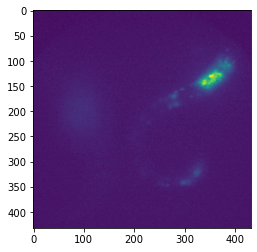

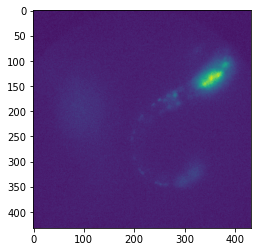

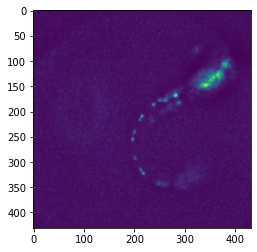

In [ ]:
# plt.imshow(np.real(np.reshape(im_ev_cp, (Nz, Ny, Nx), order = 'C')[19,49:481,49:481].get()))
# plt.figure(2)
# plt.imshow(stack[273,13,:,:])
# EVdeconv = np.reshape(est, (Nz, Ny, Nx), order='C')[(z_pad+1):(z_pad+ZZ),(xy_pad+1):(xy_pad+XX), (xy_pad+1):(xy_pad+YY)] #% deconvolution results
# maxEV = np.max(np.real(EVdeconv[:]))
# print(maxEV)
# EVdeconv = (np.real(EVdeconv)/maxEV) * (2^16 - 1)
# plt.figure(3)
# plt.imshow(np.real(EVdeconv[13,:,:].get()))

In [ ]:
import pandas as pd
print(psf.shape)
print(psf)

#plibt = np.uint16((psf/np.max(psf))*(2**16 - 1))
#print(plibt.shape)
tifffile.imwrite("psfdouble.tif", psf)

(41, 532, 532)
[[[1.64456700e-12 1.72682715e-12 1.81286797e-12 ... 1.81286797e-12
   1.72682715e-12 1.64456700e-12]
  [1.72682715e-12 1.81320190e-12 1.90354642e-12 ... 1.90354642e-12
   1.81320190e-12 1.72682715e-12]
  [1.81286797e-12 1.90354642e-12 1.99839245e-12 ... 1.99839245e-12
   1.90354642e-12 1.81286797e-12]
  ...
  [1.81286797e-12 1.90354642e-12 1.99839245e-12 ... 1.99839245e-12
   1.90354642e-12 1.81286797e-12]
  [1.72682715e-12 1.81320190e-12 1.90354642e-12 ... 1.90354642e-12
   1.81320190e-12 1.72682715e-12]
  [1.64456700e-12 1.72682715e-12 1.81286797e-12 ... 1.81286797e-12
   1.72682715e-12 1.64456700e-12]]

 [[4.48043036e-13 4.72941078e-13 4.99120847e-13 ... 4.99120847e-13
   4.72941078e-13 4.48043036e-13]
  [4.72941078e-13 4.99222719e-13 5.26857316e-13 ... 5.26857316e-13
   4.99222719e-13 4.72941078e-13]
  [4.99120847e-13 5.26857316e-13 5.56021632e-13 ... 5.56021632e-13
   5.26857316e-13 4.99120847e-13]
  ...
  [4.99120847e-13 5.26857316e-13 5.56021632e-13 ... 5.56021632